In [1]:
#@title Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import time
from sklearn.model_selection import GridSearchCV

In [2]:
#@title load dataset
df = pd.read_csv('climate.csv')
df.head()

,YEAR,MO,DY,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR
0,2010,1,1,27.76,20.91,24.33,29.05,11.52,34.08,22.55,15.87,70.19,0.04
1,2010,1,2,27.95,20.59,24.27,29.15,11.91,34.51,22.59,15.56,68.31,0.08
2,2010,1,3,28.27,19.48,23.87,29.31,12.86,35.60,22.74,14.59,63.88,0.07
3,2010,1,4,27.76,19.04,23.40,28.87,13.23,34.96,21.73,14.28,64.94,0.10
4,2010,1,5,27.91,17.99,22.95,28.55,13.23,35.17,21.94,13.43,60.75,0.16


In [3]:
#@title Shape of the dataset
print('The dataset has {} variables with {} observations (rows).'.format(df.shape[1], df.shape[0]))

The dataset has 13 variables with 4838 observations (rows).


In [4]:
#@title structure of the dataset
print('Structure of the Dataset')
print('='*40)
print('')
df.info()

Structure of the Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4838 entries, 0 to 4837
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   YEAR         4838 non-null   int64  
 1   MO           4838 non-null   int64  
 2   DY           4838 non-null   int64  
 3   T2M          4838 non-null   float64
 4   T2MDEW       4838 non-null   float64
 5   T2MWET       4838 non-null   float64
 6   TS           4838 non-null   float64
 7   T2M_RANGE    4838 non-null   float64
 8   T2M_MAX      4838 non-null   float64
 9   T2M_MIN      4838 non-null   float64
 10  QV2M         4838 non-null   float64
 11  RH2M         4838 non-null   float64
 12  PRECTOTCORR  4838 non-null   float64
dtypes: float64(10), int64(3)
memory usage: 491.5 KB


In [5]:
#@title Check for missing values
df.isna().sum()

YEAR           0
MO             0
DY             0
T2M            0
T2MDEW         0
T2MWET         0
TS             0
T2M_RANGE      0
T2M_MAX        0
T2M_MIN        0
QV2M           0
RH2M           0
PRECTOTCORR    0
dtype: int64

# **Data Preprocessing**

In [6]:
df.columns

Index(['YEAR', 'MO', 'DY', 'T2M', 'T2MDEW', 'T2MWET', 'TS', 'T2M_RANGE',
       'T2M_MAX', 'T2M_MIN', 'QV2M', 'RH2M', 'PRECTOTCORR'],
      dtype='object')

In [7]:
#@title Rename the columns
col_names = ['year', 'month', 'day', 'temperature', 'dew', 'wet bulb temperature', 'earth skin temperature','temperature range', 'maximum temperature',
 'minimum temperature', 'humidity', 'relative humidity', 'precipitation']

df.columns = col_names
df.columns

Index(['year', 'month', 'day', 'temperature', 'dew', 'wet bulb temperature',
       'earth skin temperature', 'temperature range', 'maximum temperature',
       'minimum temperature', 'humidity', 'relative humidity',
       'precipitation'],
      dtype='object')

In [8]:
df.head()

,year,month,day,temperature,dew,wet bulb temperature,earth skin temperature,temperature range,maximum temperature,minimum temperature,humidity,relative humidity,precipitation
0,2010,1,1,27.76,20.91,24.33,29.05,11.52,34.08,22.55,15.87,70.19,0.04
1,2010,1,2,27.95,20.59,24.27,29.15,11.91,34.51,22.59,15.56,68.31,0.08
2,2010,1,3,28.27,19.48,23.87,29.31,12.86,35.60,22.74,14.59,63.88,0.07
3,2010,1,4,27.76,19.04,23.40,28.87,13.23,34.96,21.73,14.28,64.94,0.10
4,2010,1,5,27.91,17.99,22.95,28.55,13.23,35.17,21.94,13.43,60.75,0.16


In [9]:
#@title create a date variable
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df['date'].head()

0   2010-01-01
1   2010-01-02
2   2010-01-03
3   2010-01-04
4   2010-01-05
Name: date, dtype: datetime64[ns]

In [10]:
#@title set date as index
df.set_index('date', inplace = True)
df.head()

,year,month,day,temperature,dew,wet bulb temperature,earth skin temperature,temperature range,maximum temperature,minimum temperature,humidity,relative humidity,precipitation
date,,,,,,,,,,,,,
2010-01-01,2010,1,1,27.76,20.91,24.33,29.05,11.52,34.08,22.55,15.87,70.19,0.04
2010-01-02,2010,1,2,27.95,20.59,24.27,29.15,11.91,34.51,22.59,15.56,68.31,0.08
2010-01-03,2010,1,3,28.27,19.48,23.87,29.31,12.86,35.60,22.74,14.59,63.88,0.07
2010-01-04,2010,1,4,27.76,19.04,23.40,28.87,13.23,34.96,21.73,14.28,64.94,0.10
2010-01-05,2010,1,5,27.91,17.99,22.95,28.55,13.23,35.17,21.94,13.43,60.75,0.16


In [11]:
#@title inspect dataset structure again
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4838 entries, 2010-01-01 to 2023-03-31
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    4838 non-null   int64  
 1   month                   4838 non-null   int64  
 2   day                     4838 non-null   int64  
 3   temperature             4838 non-null   float64
 4   dew                     4838 non-null   float64
 5   wet bulb temperature    4838 non-null   float64
 6   earth skin temperature  4838 non-null   float64
 7   temperature range       4838 non-null   float64
 8   maximum temperature     4838 non-null   float64
 9   minimum temperature     4838 non-null   float64
 10  humidity                4838 non-null   float64
 11  relative humidity       4838 non-null   float64
 12  precipitation           4838 non-null   float64
dtypes: float64(10), int64(3)
memory usage: 529.2 KB


In [12]:
df[df['humidity'] == -999]

,year,month,day,temperature,dew,wet bulb temperature,earth skin temperature,temperature range,maximum temperature,minimum temperature,humidity,relative humidity,precipitation
date,,,,,,,,,,,,,


# **EDA**

In [13]:
#@title Years coverage of the dataset
print('The dataset covers a {} years duration ranging between {} and {}'.format(df['year'].nunique(), df['year'].min(), df['year'].max()))

The dataset covers a 14 years duration ranging between 2010 and 2023


In [14]:
#@title average annual climatologies
annual_climatology = df.groupby('year').aggregate({'temperature': 'mean', 'humidity': 'mean', 'precipitation': 'mean'})
annual_climatology

,temperature,humidity,precipitation
year,,,
2010,26.158356,16.986959,3.978822
2011,25.273534,16.753123,4.269781
2012,25.490219,16.308224,4.133880
2013,26.083808,16.098411,2.873753
2014,26.018493,16.667945,3.807945
2015,25.929260,16.319808,3.564877
2016,26.533279,16.261967,3.526858
2017,25.968438,16.870301,3.782767
2018,25.826932,16.645315,4.313425


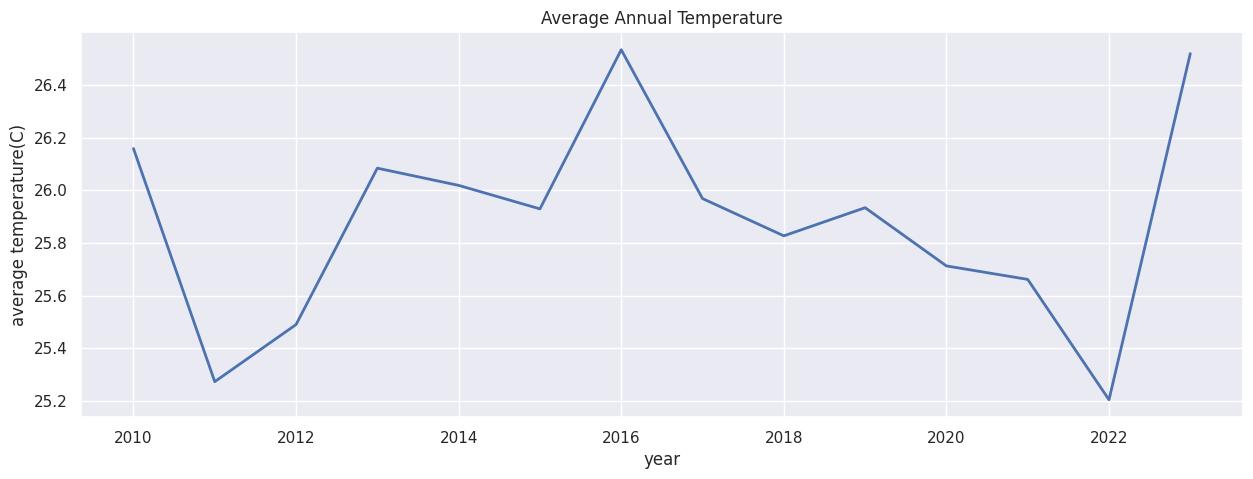

In [15]:
#@title visualize average annual climatology (temperature)
sns.set(rc = {'figure.figsize': (15, 5)})
annual_climatology['temperature'].plot(linewidth = 2)

# label chart
plt.ylabel('average temperature(C)')
plt.title('Average Annual Temperature');

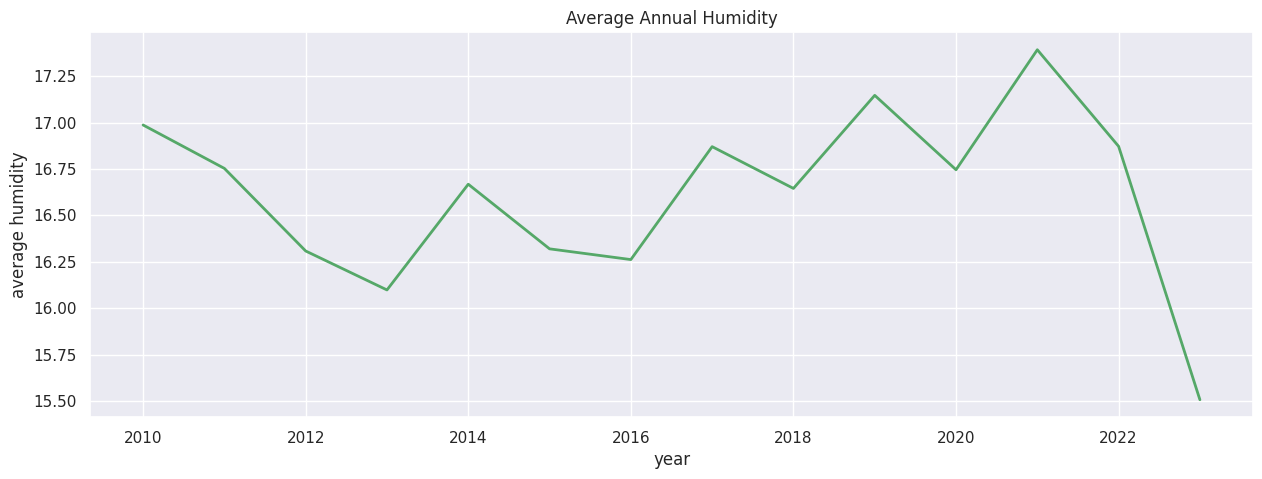

In [16]:
#@title visualize average annual climatology (humidity)
annual_climatology['humidity'].plot(linewidth = 2, color = 'g')

# label chart
plt.ylabel('average humidity')
plt.title('Average Annual Humidity');

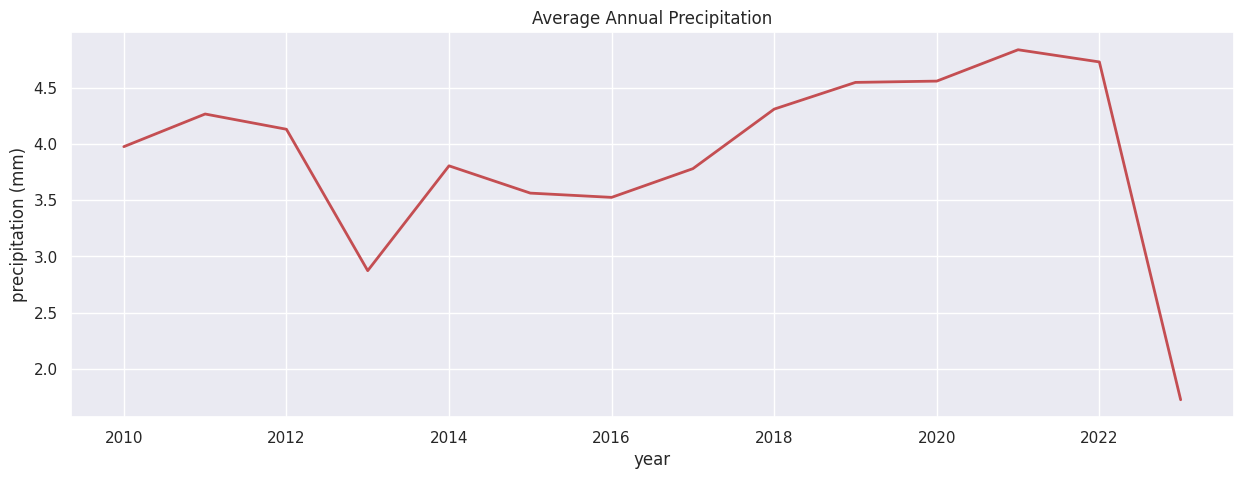

In [17]:
#@title visualize average annual climatology (precipitation/rainfall)
annual_climatology['precipitation'].plot(linewidth = 2, color = 'r')

# label chart
plt.ylabel('precipitation (mm)')
plt.title('Average Annual Precipitation');

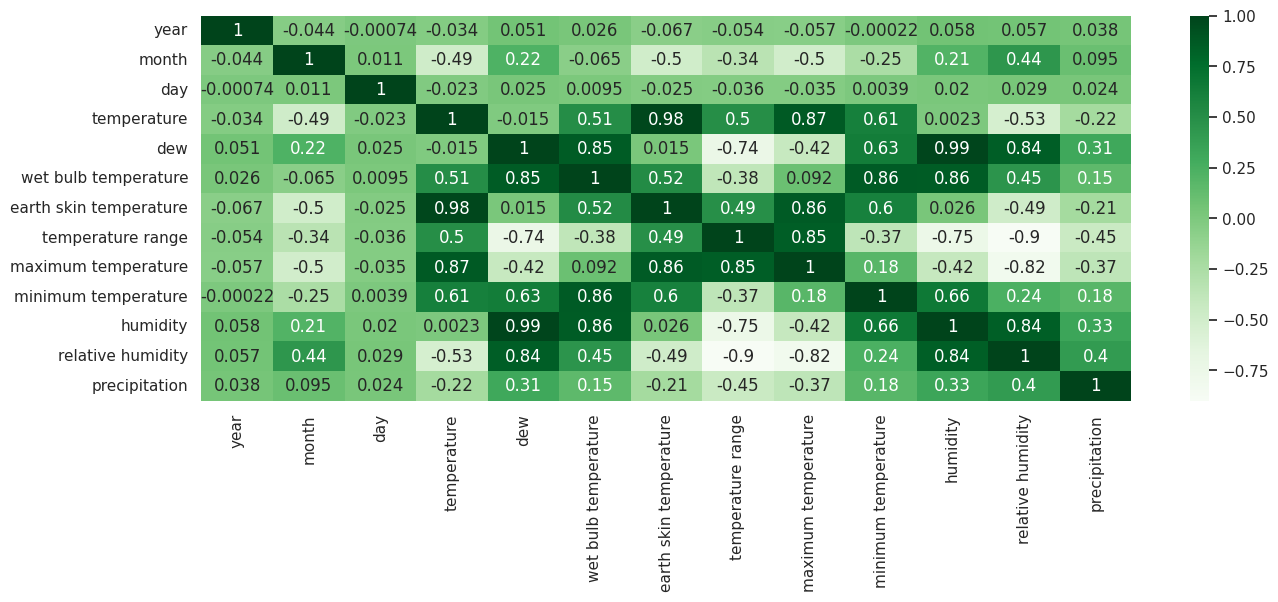

In [18]:
#@title Calculate Correlation between climatologies
correlation = df.corr()

# visualize correlation
sns.heatmap(correlation, cmap = 'Greens', annot = True);

Precipitation has a significant negative correlation with temperature and significant postiive correlation with humidity. This means that, when temperatures are high, it rains not so much and the vice versa. This is awesome and can be investigated further to discover the underlying patterns. It is also known that `month` has a significant effect on all the climatologies.

In [19]:
#@title Average Monthly Climatology
monthly_climatology = df.groupby('month').aggregate({'temperature': 'mean', 'humidity': 'mean', 'precipitation': 'mean'})
monthly_climatology

,temperature,humidity,precipitation
month,,,
1,26.298641,13.536060,0.571060
2,27.824228,15.107468,1.766937
3,27.311982,17.239539,3.883364
4,26.985513,17.881692,3.919077
5,26.255658,18.062010,5.365087
6,25.082436,17.698846,7.287231
7,24.360397,16.903548,4.635310
8,24.521414,16.467246,2.684988
9,24.976436,17.112795,7.145436


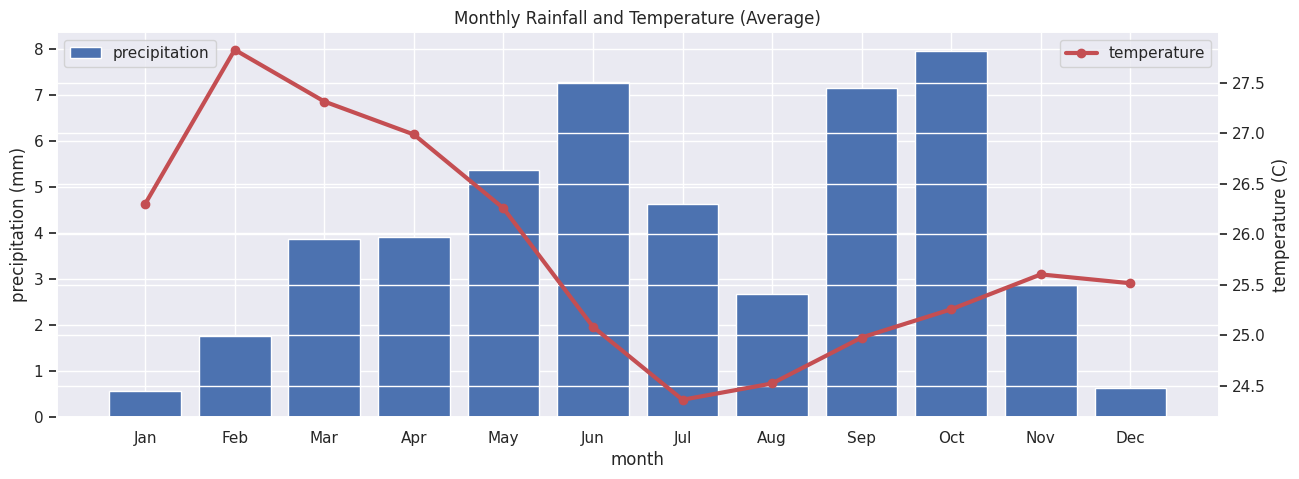

In [20]:
#@title Discovering the relationship between temperature and precipitation

# list of month names
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# set frame for plotting
fig, ax1 = plt.subplots()
# plot rainfall
ax1.bar(df.month.unique(), monthly_climatology.precipitation, label = 'precipitation')

# label chart
plt.xlabel('month')
plt.ylabel('precipitation (mm)')
plt.title('Monthly Rainfall and Temperature (Average)')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], months, rotation = 0)
plt.legend(loc = 'upper left')

# set a secondary axis for tempereature
ax2 = ax1.twinx()

# plot temperature
ax2.plot(monthly_climatology.temperature, linewidth = 3, marker = 'o', label = 'temperature', color = 'r')
plt.ylabel('temperature (C)')
plt.legend();

In [21]:
#@title Discovering the relationships among monthly climatologies

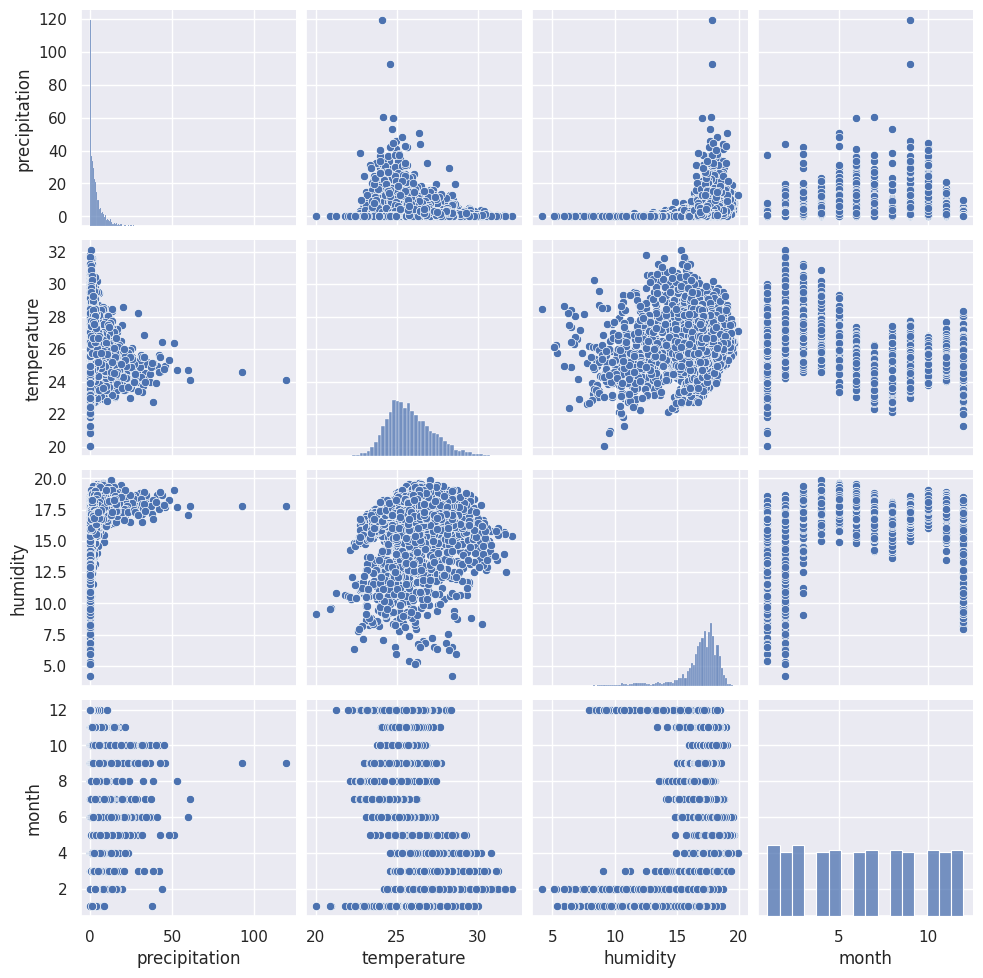

In [22]:
sns.pairplot(df[['precipitation', 'temperature', 'humidity', 'month']]);

In [23]:
df.groupby('month').aggregate({'precipitation': 'mean'})

,precipitation
month,
1,0.571060
2,1.766937
3,3.883364
4,3.919077
5,5.365087
6,7.287231
7,4.635310
8,2.684988
9,7.145436


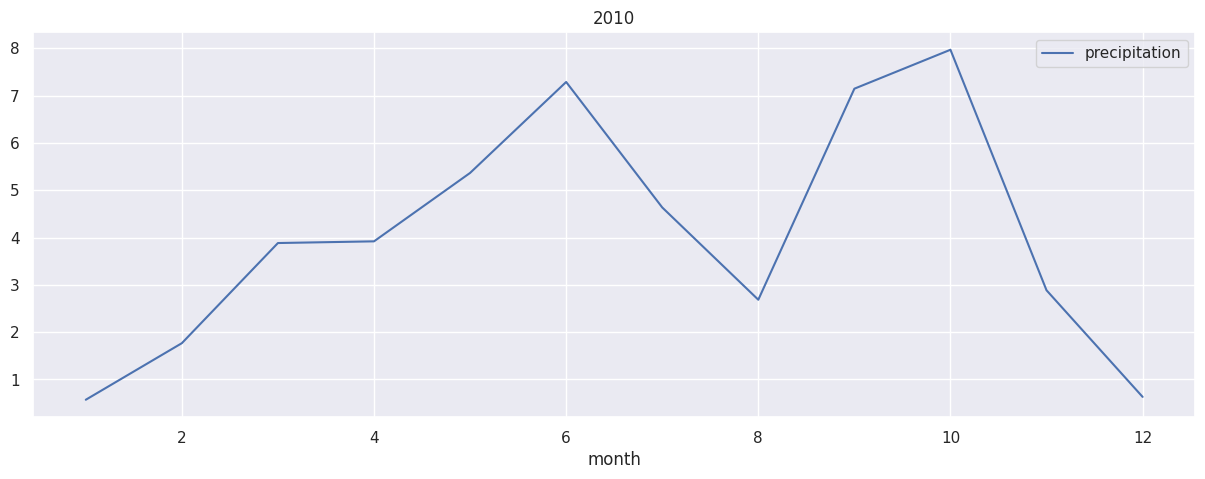

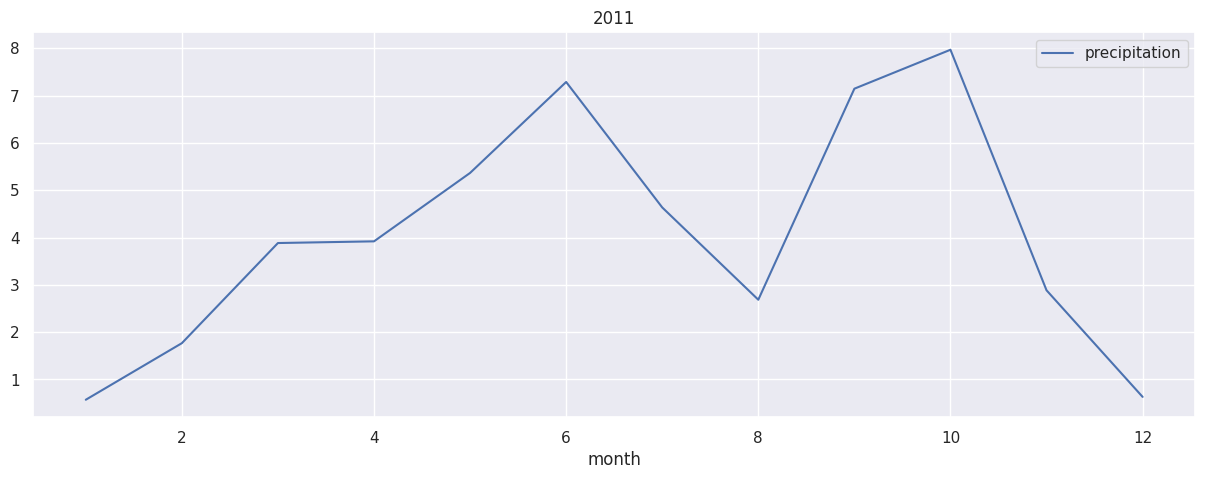

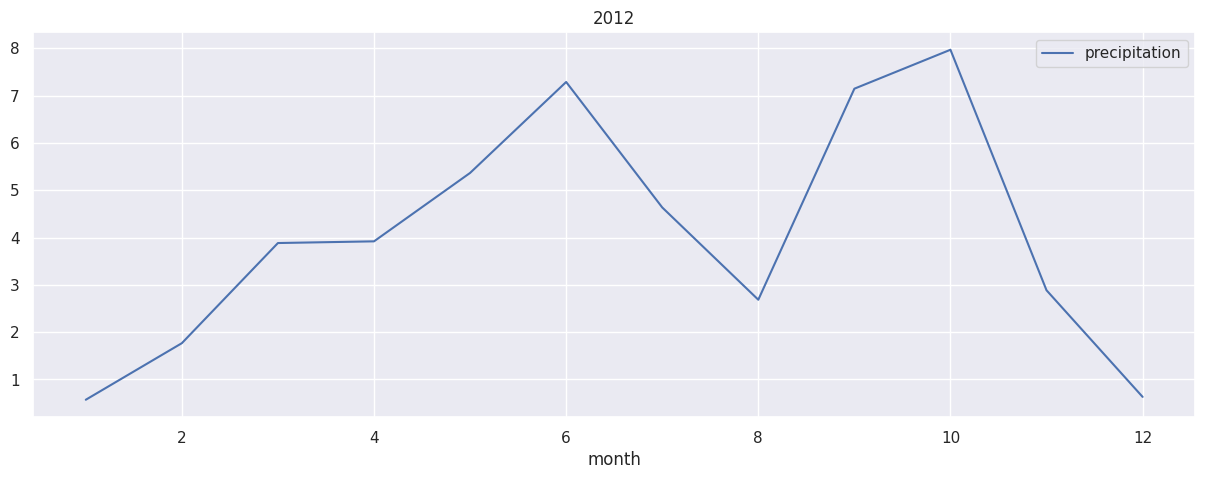

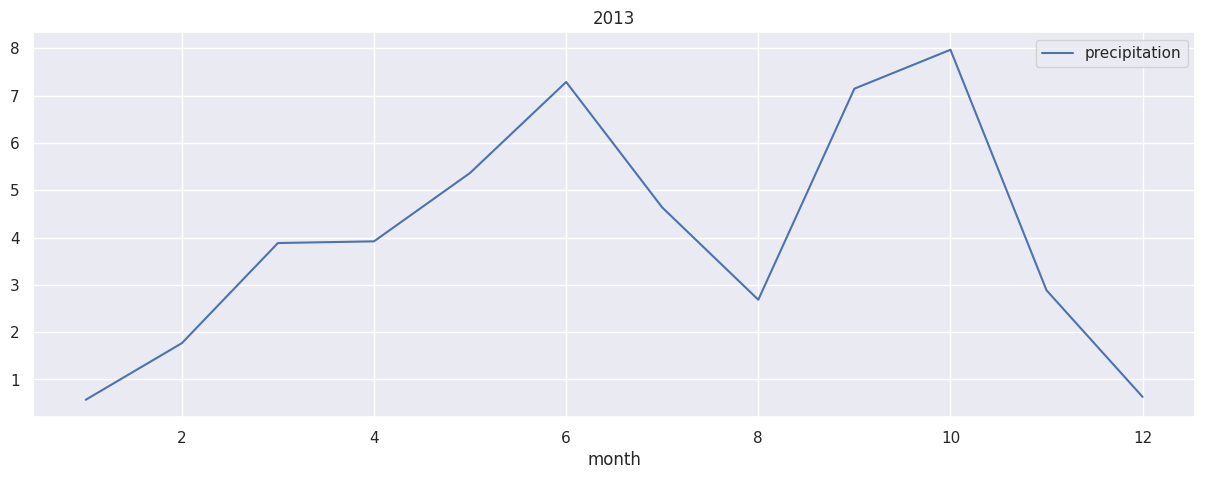

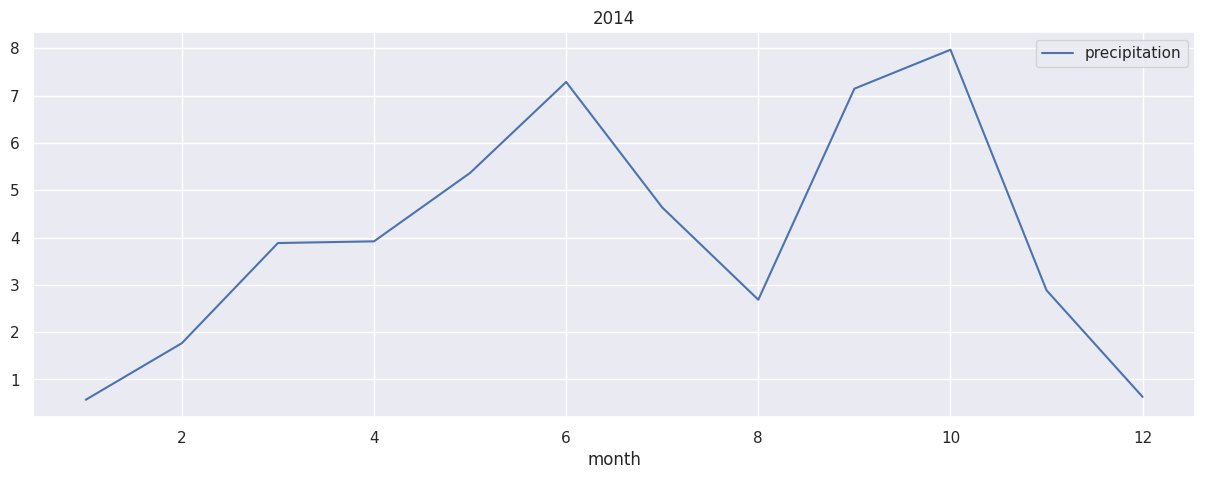

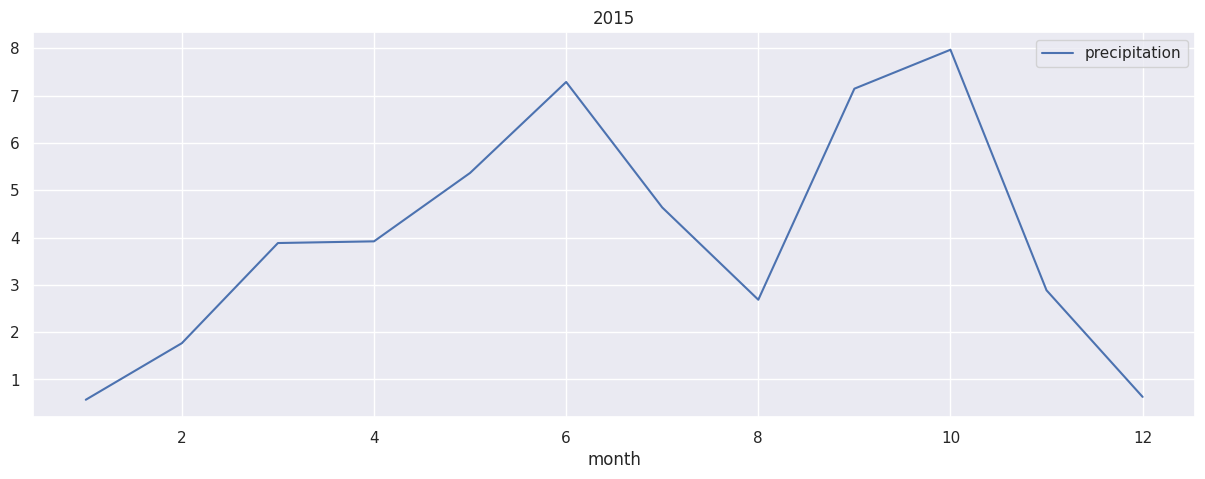

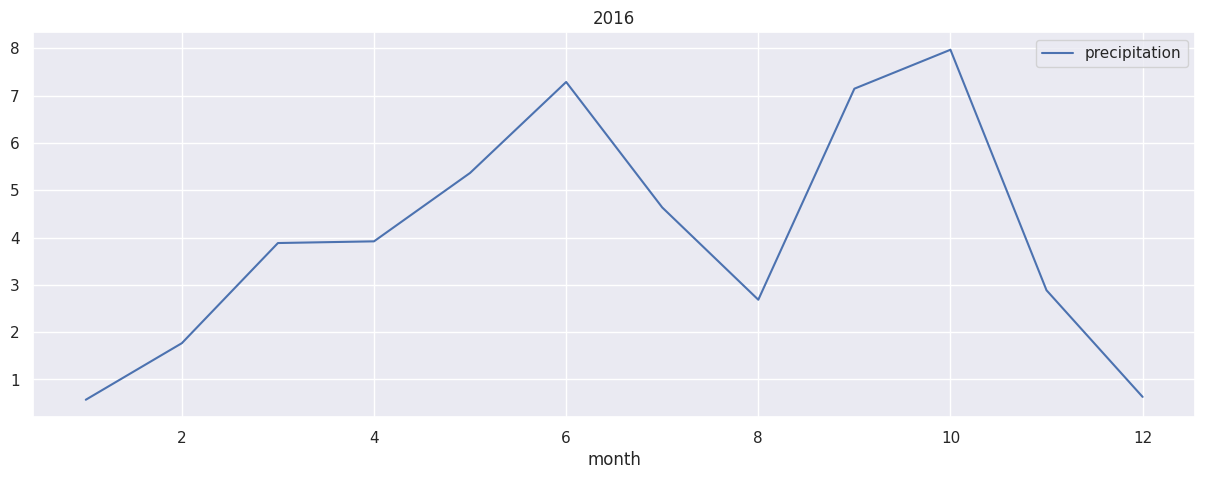

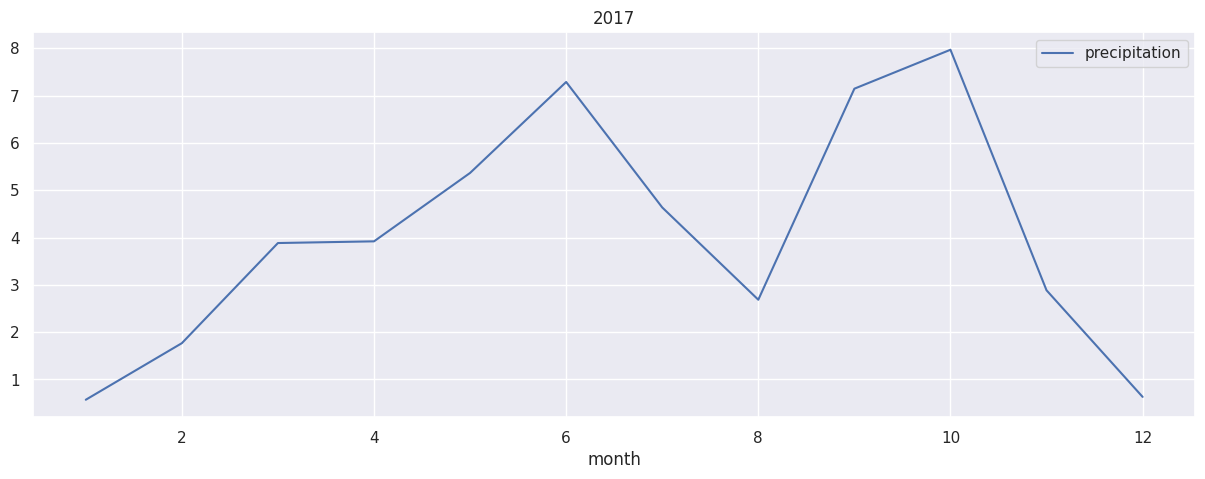

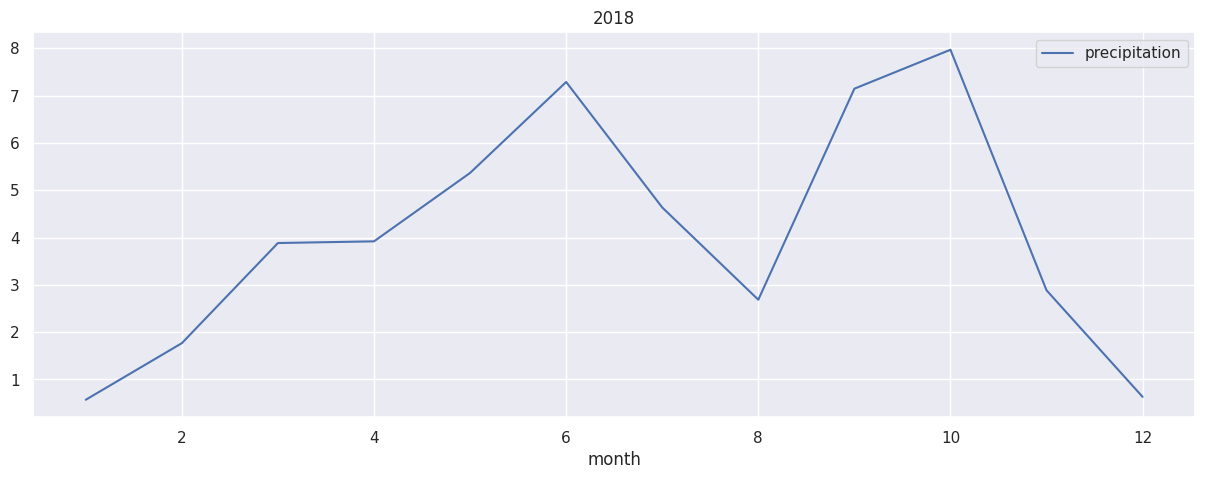

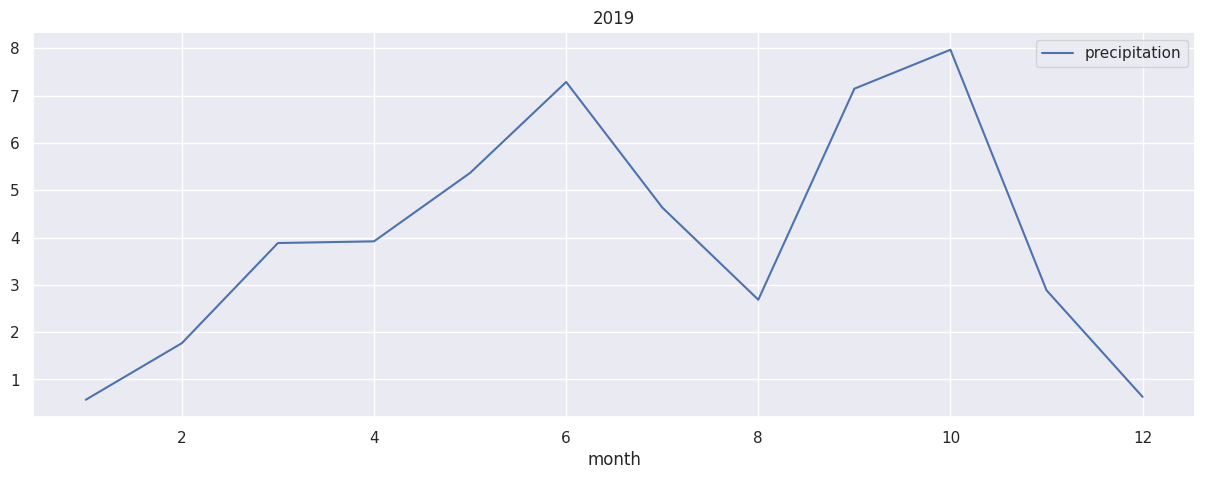

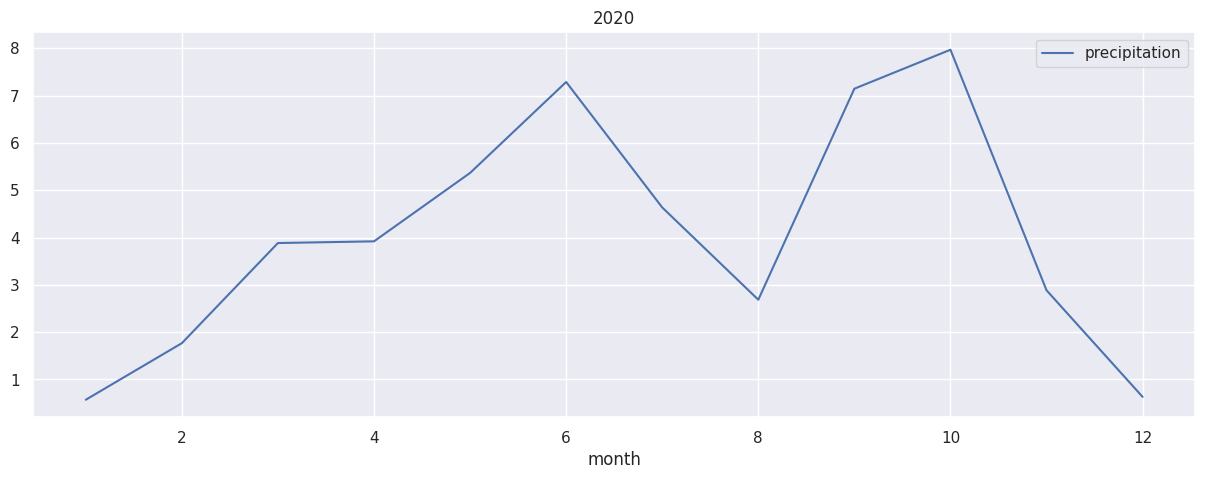

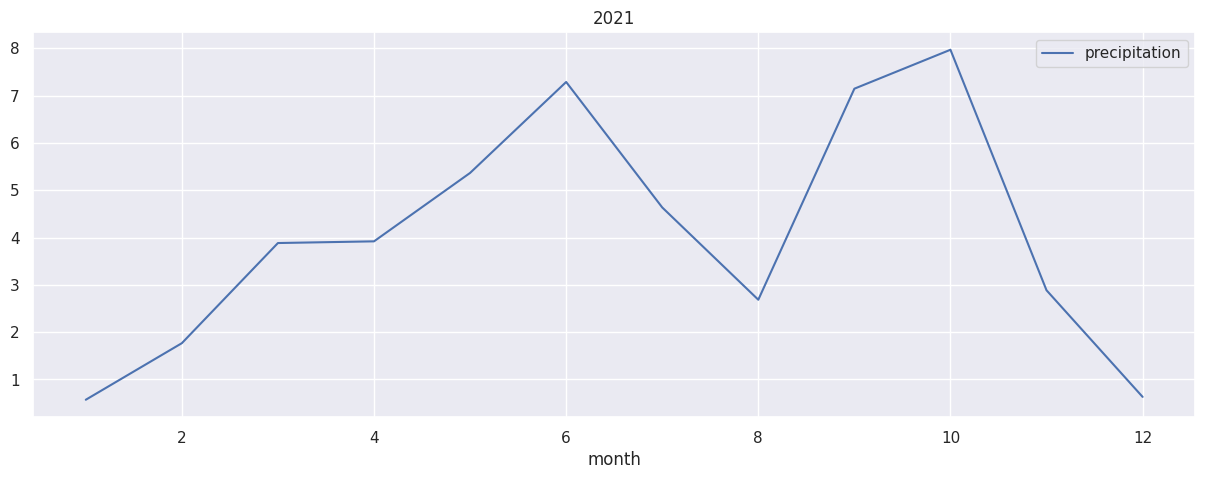

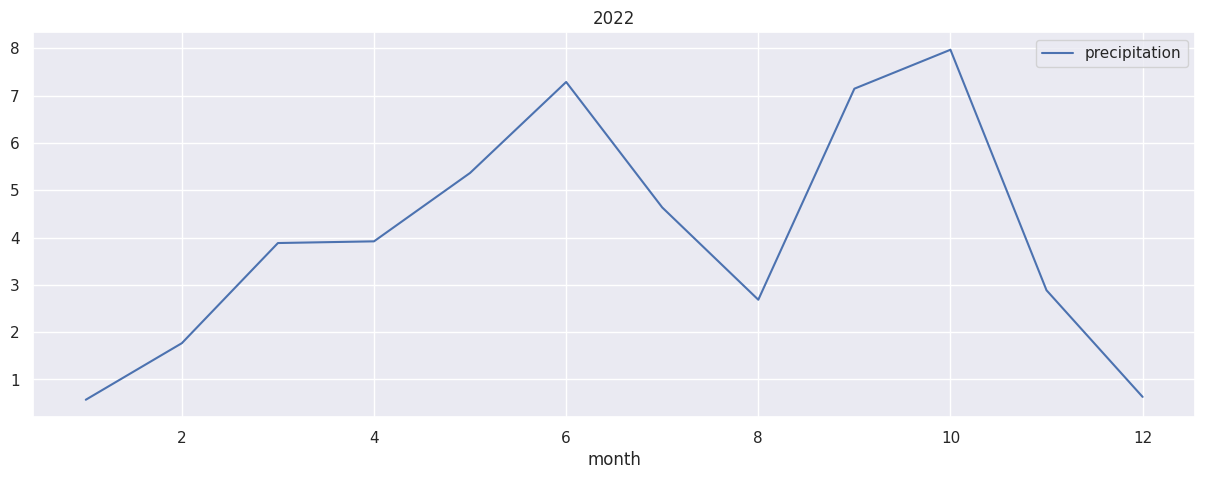

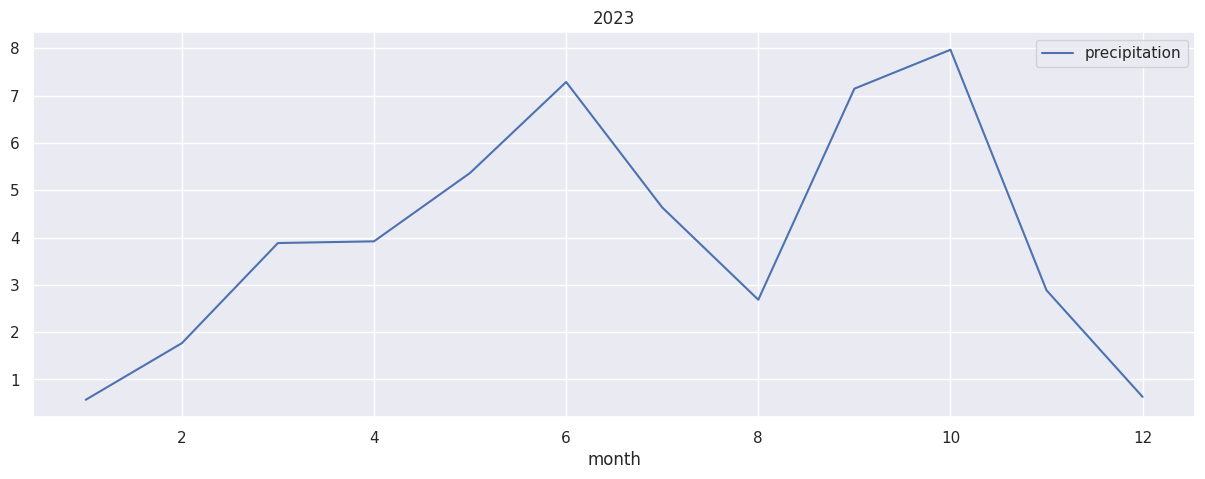

In [24]:
for year in df['year'].unique():
  fig, ax = plt.subplots()
  df.groupby('month').aggregate({'precipitation': 'mean'}).plot(ax = ax)
  plt.title(year);

In [25]:
# Group the data by year and month
grouped_data = df.groupby(["year", "month"]).aggregate({'precipitation': 'mean'})
grouped_data.head(20)

precipitation
year month               
2010 1           1.052258
     2           1.281071
     3           2.595484
     4           4.097000
     5           4.814516
     6           8.751000
     7           3.220645
     8           3.618065
     9           5.152000
     10          8.162903
     11          3.767667
     12          1.160968
2011 1           0.439677
     2           3.351429
     3           4.060000
     4           6.022667
     5           4.029677
     6           6.612333
     7           9.141935
     8           2.361935

In [26]:
#@title Prepare dataset for model training
temperature = df['temperature']    # model only temperature and rainfall
precipitation = df['precipitation']
temperature.head()

date
2010-01-01    27.76
2010-01-02    27.95
2010-01-03    28.27
2010-01-04    27.76
2010-01-05    27.91
Name: temperature, dtype: float64

In [27]:
#@title Split dataset for training and evaluating
cutoff = int(0.8 * df.shape[0])     # set cutoff point

# temperature
training_temp = temperature.iloc[:cutoff]
test_temp = temperature.iloc[cutoff:]

print('Shape of training temperature dataset:', training_temp.shape)
print('Shape of testing temperature dataset:', test_temp.shape)

# precipitation
training_prec = precipitation.iloc[:cutoff]
test_prec = precipitation.iloc[cutoff:]

print('Shape of training precipitation dataset:', training_prec.shape)
print('Shape of testing precipitation dataset:', test_prec.shape)

Shape of training temperature dataset: (3870,)
Shape of testing temperature dataset: (968,)
Shape of training precipitation dataset: (3870,)
Shape of testing precipitation dataset: (968,)


# Time Series plots

In [28]:
# temperature
fig = px.line(temperature, title = 'Time Series Plot of Temperature (C)')
fig.show()

In [29]:
# precipitation
fig = px.line(precipitation, title = 'Time Series Plot of Precipitation (C)')
fig.show()

In [30]:
#@title Calculate the baseline mean absolute error and mean absolute percentage error

# temperature
temp_mean = training_temp.mean()
temp_mean = [temp_mean] * len(training_temp)
baseline_temp_mae = mean_absolute_error(training_temp, temp_mean)
print('Baseline MAE for temperature:', round(baseline_temp_mae, 4))

# precipitation
prec_mean = training_prec.mean()
prec_mean = [prec_mean] * len(training_prec)
baseline_prec_mae = mean_absolute_error(training_prec, prec_mean)
print('Baseline MAE for precipitation:', round(baseline_prec_mae, 4))

Baseline MAE for temperature: 1.2029
Baseline MAE for precipitation: 3.5376


# Build Autoregression models for temperature and precipitation

In [31]:
# @title perform hyperparameter search for better performance
lags = range(5, 100, 5)
for lag in lags:
  temp_ar = AutoReg(training_temp, lags = lag).fit()
  y_pred = temp_ar.predict()
  mae = mean_absolute_error(training_temp[lag:], y_pred[lag:])
  print('for lag: {}, MAE is {}'.format(lag, mae))

for lag: 5, MAE is 0.4873517632895026
for lag: 10, MAE is 0.48207447713153
for lag: 15, MAE is 0.48190094467624894
for lag: 20, MAE is 0.482097214791074


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so infe

for lag: 25, MAE is 0.4818106010048368
for lag: 30, MAE is 0.4815958541589822
for lag: 35, MAE is 0.4808902302069371
for lag: 40, MAE is 0.48088184741872014


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



for lag: 45, MAE is 0.4788059248476788
for lag: 50, MAE is 0.47783952370914745


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



for lag: 55, MAE is 0.4771170362032264
for lag: 60, MAE is 0.4761879711710351
for lag: 65, MAE is 0.4761636887435791


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



for lag: 70, MAE is 0.47583300784359206
for lag: 75, MAE is 0.47572960177919515


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



for lag: 80, MAE is 0.47519560341449907
for lag: 85, MAE is 0.4745132886869234


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



for lag: 90, MAE is 0.47406029107630393


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



for lag: 95, MAE is 0.47335435039224416


There is no so much significant differences between the MAEs of the lags so I will build the model using a lag of `5`

In [32]:
#@title Rebuild temperature model with a lag of 5
temp_ar = AutoReg(training_temp, lags = 5).fit()
y_pred = temp_ar.predict().tolist()
print('Mean Absolute Error:', mean_absolute_error(training_temp[5:], y_pred[5:]).round(4))
print('')
print('First 15 predictions')
print('=' * 25)
y_pred[5:20]

Mean Absolute Error: 0.4874

First 15 predictions


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



[27.814551586409852,
 27.330558593616963,
 27.722627415178675,
 27.502889381540044,
 27.483250020252335,
 27.508439503265578,
 27.790887252626064,
 27.474780511872044,
 27.305889778370783,
 27.86314848846312,
 28.004480075825352,
 28.071191811147493,
 28.12834155302277,
 28.055406403049105,
 27.919145406806216]

In [33]:
temp_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:            temperature   No. Observations:                 3870
Model:                     AutoReg(5)   Log Likelihood               -3725.741
Method:               Conditional MLE   S.D. of innovations              0.634
Date:                Sun, 17 Dec 2023   AIC                           7465.481
Time:                        14:35:48   BIC                           7509.299
Sample:                    01-06-2010   HQIC                          7481.040
                         - 08-05-2020                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.5398      0.189      8.161      0.000       1.170       1.910
temperature.L1     0.7480      0.016     46.683      0.000       0.717       0.779
temperature.L2    -0.0142      0.020     -0.709      0.479      -0.053       0.025
temperature.L3     0.0966      0.020      4.838      0.000       0.057       0.136
temperature.L4     0.0215      0.020      1.075      0.282      -0.018       0.061
temperature.L5     0.0885      0.016      5.521      0.000       0.057       0.120
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0374           -0.0000j            1.0374           -0.0000
AR.2            0.7578           -1.5203j            1.6987           -0.1764
AR.3            0.7578           +1.5203j            1.6987            0.1764
AR.4           -1.3982           -1.3484j            1.9425           -0.3779
AR.5           -1.3982           +1.3484j            1.9425            0.3779
-----------------------------------------------------------------------------
"""

The Equation of the AR temperature model can be written as:
$y_t = 0.7480 y_{t-1} -0.0142 y_{t-2} + 0.0966 y_{t-3} + 0.0215 y_{t-4}  + 0.0885 y_{t-5} + 1.5398$

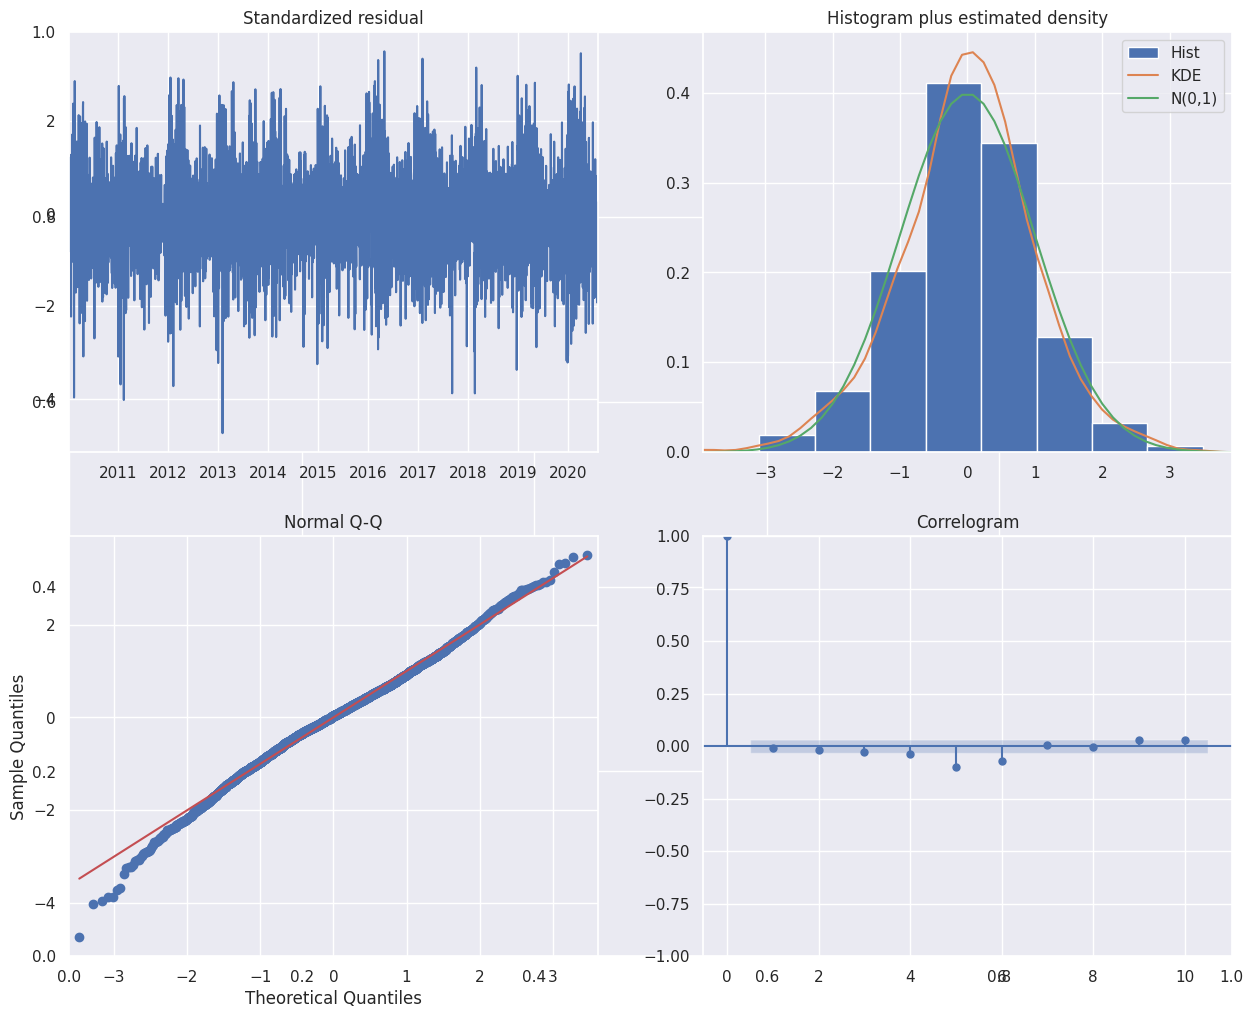

In [34]:
#@title Diagnosing the model's performance
fig, ax = plt.subplots(figsize=(15, 12))
temp_ar.plot_diagnostics(fig = fig);

In [35]:
#@title convert actual values and model predictions into a dataframe
df_temp = pd.DataFrame(
    {
        'true value': training_temp.values[5:],
        'predicted': y_pred[5:]
    },
    index = training_temp.index[5:]
)
df_temp.head()

,true value,predicted
date,,
2010-01-06,27.30,27.814552
2010-01-07,27.77,27.330559
2010-01-08,27.62,27.722627
2010-01-09,27.53,27.502889
2010-01-10,27.64,27.483250


In [36]:
#@title Visualize model predictions
fig = px.line(df_temp, title = 'Performance of the Temperature AR(5) Model')
fig.show()

In [37]:
#@title Build Autoregressive model for rainfall
lags = range(5, 30)
for lag in lags:
  prec_ar = AutoReg(training_prec, lags = lag).fit()
  y_pred = prec_ar.predict()
  mae = mean_absolute_error(training_prec[lag:], y_pred[lag:])
  print('for lag: {}, MAE is {}'.format(lag, mae))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so infe

for lag: 5, MAE is 2.589744054760028
for lag: 6, MAE is 2.582890925259674
for lag: 7, MAE is 2.570370579150059
for lag: 8, MAE is 2.57087021022458
for lag: 9, MAE is 2.5700927721641924
for lag: 10, MAE is 2.5543800608093776
for lag: 11, MAE is 2.551259382308929
for lag: 12, MAE is 2.5494142632474124


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so infe

for lag: 13, MAE is 2.5463179903845403
for lag: 14, MAE is 2.542749011123565
for lag: 15, MAE is 2.540955112611882
for lag: 16, MAE is 2.535198543170595
for lag: 17, MAE is 2.5356532102824203
for lag: 18, MAE is 2.534715365143122
for lag: 19, MAE is 2.5358417438133616


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so infe

for lag: 20, MAE is 2.5357988966256864
for lag: 21, MAE is 2.535498349793581
for lag: 22, MAE is 2.5348745370726484
for lag: 23, MAE is 2.5365339399487126
for lag: 24, MAE is 2.53893739565574
for lag: 25, MAE is 2.5395876492647163
for lag: 26, MAE is 2.539849350260988
for lag: 27, MAE is 2.539829769228355
for lag: 28, MAE is 2.540254114270957
for lag: 29, MAE is 2.540845305113636


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [38]:
#@title Rebuild precipitation model with a lag of 5
prec_ar = AutoReg(training_prec, lags = 5).fit()
y_pred = prec_ar.predict().tolist()
print('Mean Absolute Error:', mean_absolute_error(training_prec[5:], y_pred[5:]).round(4))
print('')
print('First 15 predictions')
print('=' * 25)
y_pred[5:20]

Mean Absolute Error: 2.5897

First 15 predictions


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



[1.3831672067112524,
 2.4977847572344825,
 2.2378272105436703,
 2.2177620043632293,
 2.154613261327612,
 2.5831811511202583,
 2.778811074668784,
 3.435292911976062,
 3.4362022598578563,
 3.116886389935004,
 3.0074474989678848,
 2.0499089756163085,
 1.8161509867850456,
 1.5754657719079599,
 1.3977414147272746]

In [39]:
#@title Explore the Precipitation model
prec_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:          precipitation   No. Observations:                 3870
Model:                     AutoReg(5)   Log Likelihood              -11410.700
Method:               Conditional MLE   S.D. of innovations              4.634
Date:                Sun, 17 Dec 2023   AIC                          22835.399
Time:                        14:35:54   BIC                          22879.217
Sample:                    01-06-2010   HQIC                         22850.959
                         - 08-05-2020                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.2973      0.105     12.314      0.000       1.091       1.504
precipitation.L1     0.4247      0.016     26.432      0.000       0.393       0.456
precipitation.L2     0.0460      0.017      2.642      0.008       0.012       0.080
precipitation.L3     0.0760      0.017      4.373      0.000       0.042       0.110
precipitation.L4     0.0772      0.017      4.433      0.000       0.043       0.111
precipitation.L5     0.0451      0.016      2.805      0.005       0.014       0.077
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2108           -0.0000j            1.2108           -0.0000
AR.2            0.4716           -1.7453j            1.8078           -0.2080
AR.3            0.4716           +1.7453j            1.8078            0.2080
AR.4           -1.9336           -1.3668j            2.3679           -0.4021
AR.5           -1.9336           +1.3668j            2.3679            0.4021
-----------------------------------------------------------------------------
"""

In [40]:
prec_ar.params

const               1.297306
precipitation.L1    0.424730
precipitation.L2    0.046022
precipitation.L3    0.076040
precipitation.L4    0.077211
precipitation.L5    0.045070
dtype: float64

The Equation of the AR precipitation model can be written as:
$y_t = 0.4247 y_{t -1} + 0.0460 y_{t -2} + 0.0760 y_{t -3} + 0.0772 y_{t -4} + 0.0451 y_{t -5} + 1.2973$

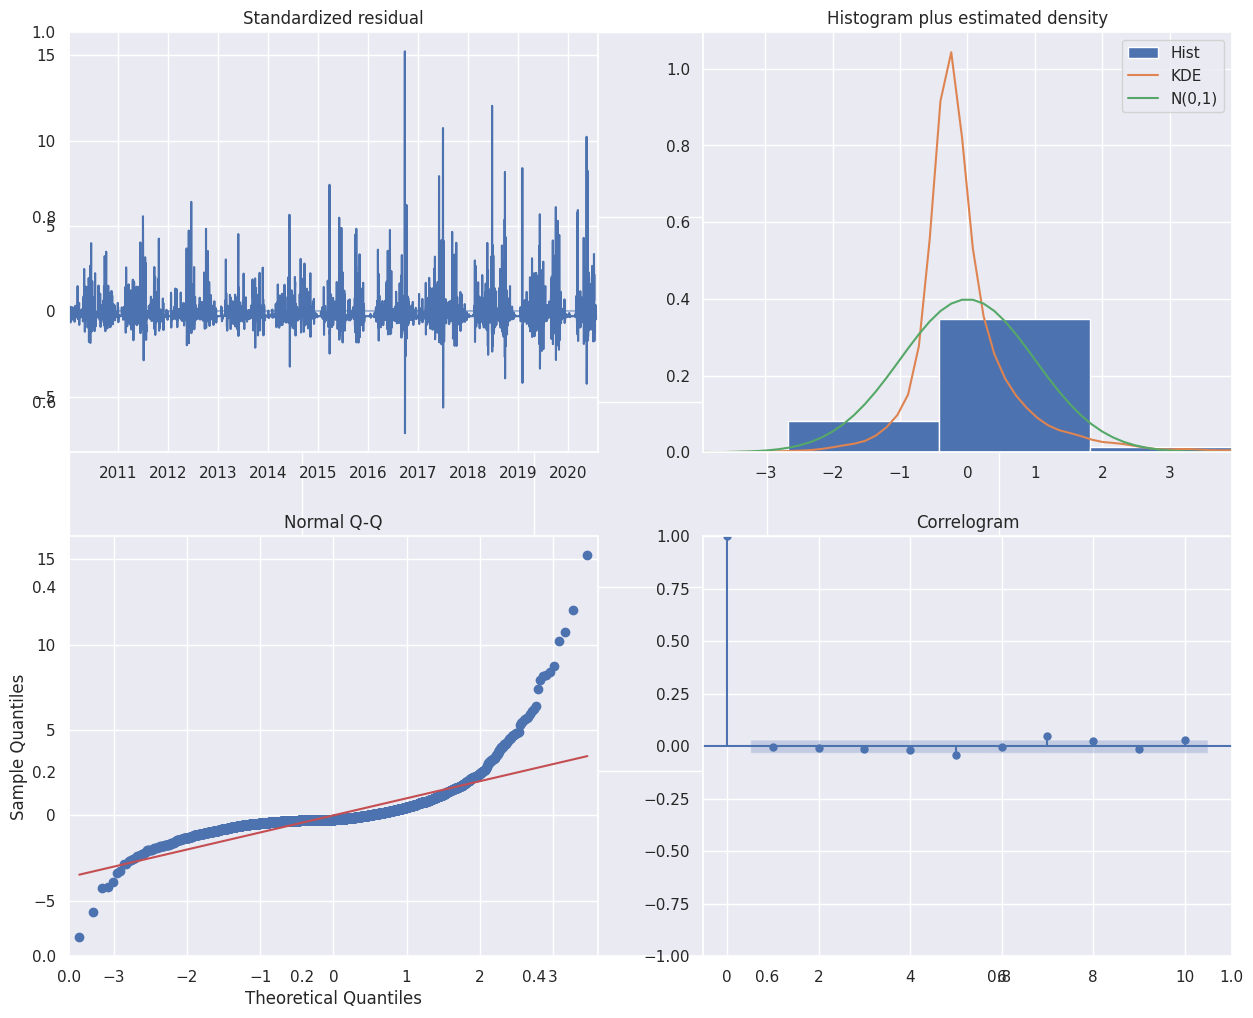

In [41]:
#@title Diagnoze the model's performance
fig, ax = plt.subplots(figsize=(15, 12))
prec_ar.plot_diagnostics(fig = fig);

According to the model diagnostics, linear models may not fit well for the precipitation dataset. A more sophiscated non-linear model will accurately capture the rainfall patterns and predict rainfall very well.

In [42]:
#@title convert rainfall model's prediction into a dataframe
df_prec = pd.DataFrame(
    {
        'true values': training_prec.values[5:],
        'predictions': y_pred[5:]
    },
    index = training_prec.index[5:]
)
df_prec.head()

,true values,predictions
date,,
2010-01-06,2.77,1.383167
2010-01-07,1.86,2.497785
2010-01-08,1.43,2.237827
2010-01-09,1.01,2.217762
2010-01-10,2.03,2.154613


In [43]:
#@title Visualize model's performance
fig = px.line(df_prec, title = 'Performance of the Precipitation AR(5) Model')
fig.show()

## Use PACF to determine the values of p for the AR(p) models too. This is also another technique to look for it
The first zero crossing value of the PACF plot is the ideal value for `p`.

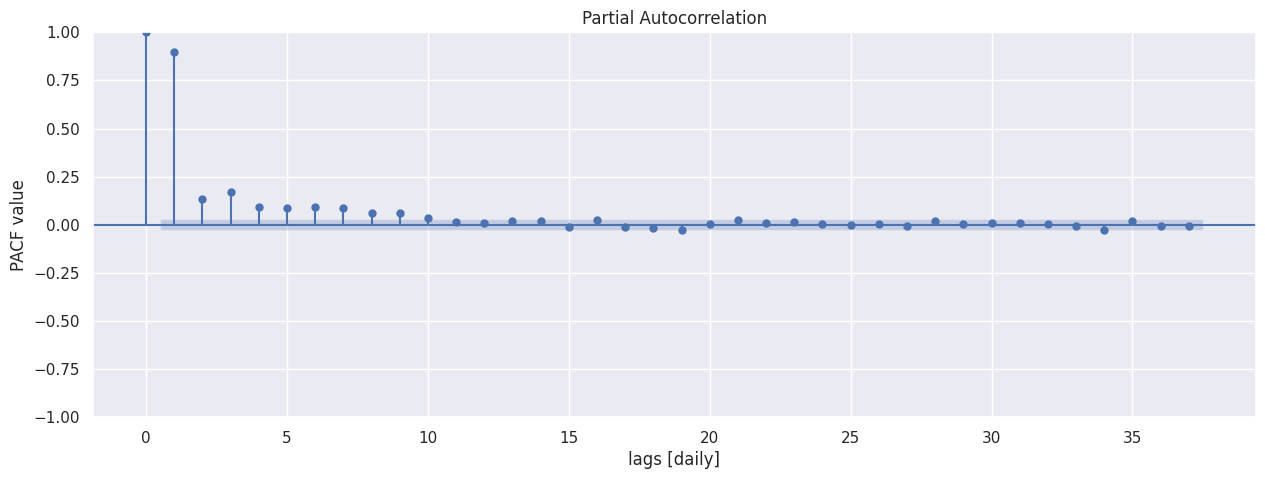

In [44]:
#@title PACF plot for temperature
plot_pacf(temperature)

# label chart
plt.xlabel('lags [daily]')
plt.ylabel('PACF value');

The ideal value for `p` is `11` for temperature modelling according to the `PACF chart`.

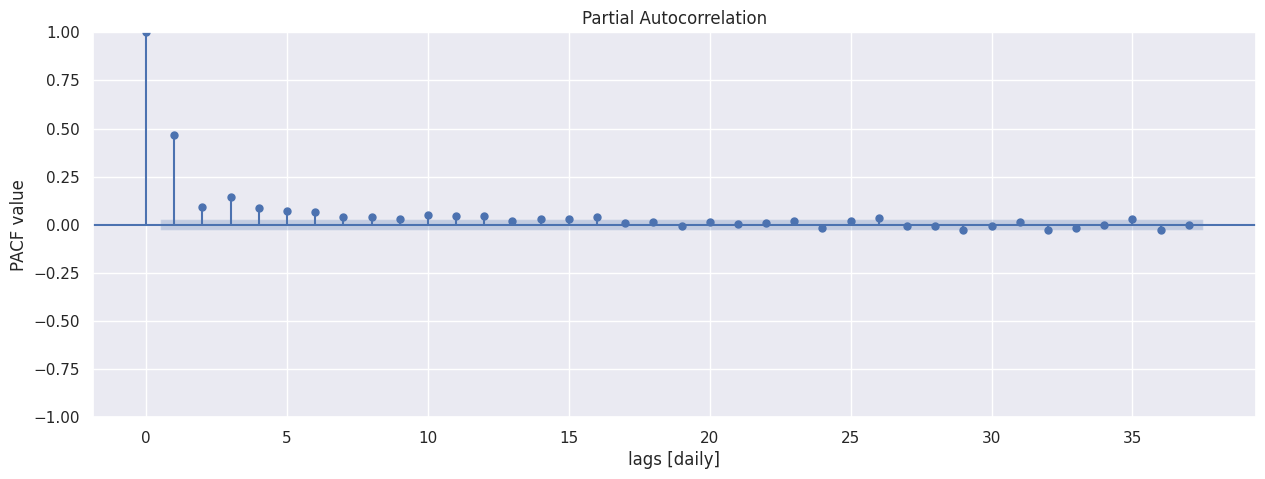

In [45]:
#@title ACF plot for precipitation
plot_pacf(precipitation)

# label chart
plt.xlabel('lags [daily]')
plt.ylabel('PACF value');

The ideal value for `p` is around `13` for precipitation modelling according to the `PACF chart`.

### Better models can be built using the `p` values from the `PACF` plot. However, I am going to do that in this project. I did this for a demonstration purpose. This is a very good way to choose the order of AR models and even ARIMA models.

# Build ARIMA model for the temperature and precipitation.
ARIMA models are very good for non-stationary time series data since it has the differencing component in it. Let's explore 🙂
It has the format ARIMA(p,d,q).

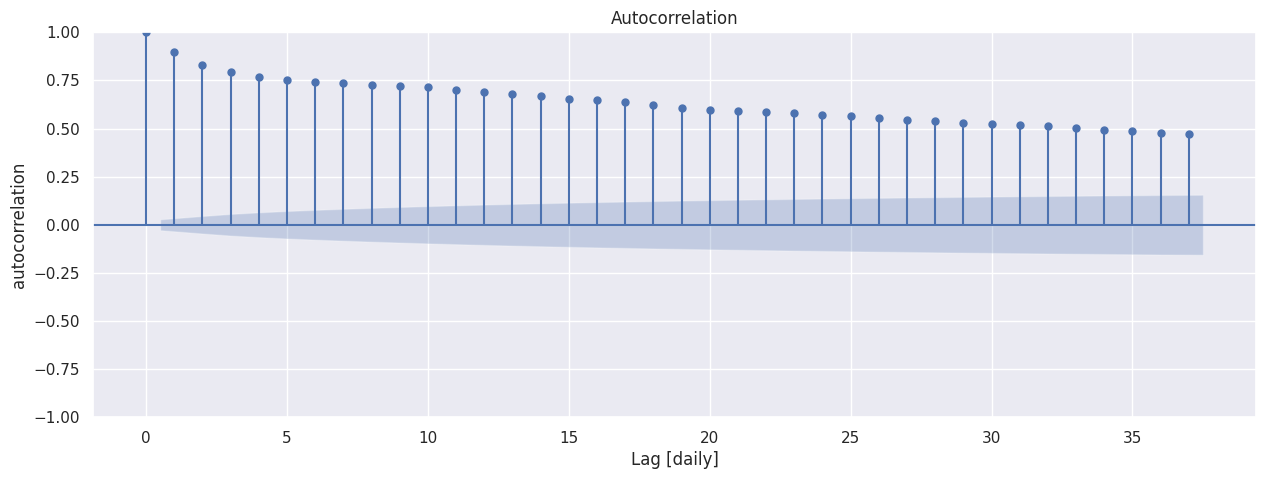

In [46]:
#@title use ACF plot to determine the q values of the ARIMA models

# temperature
plot_acf(temperature)

# label chart
plt.xlabel('Lag [daily]')
plt.ylabel('autocorrelation');

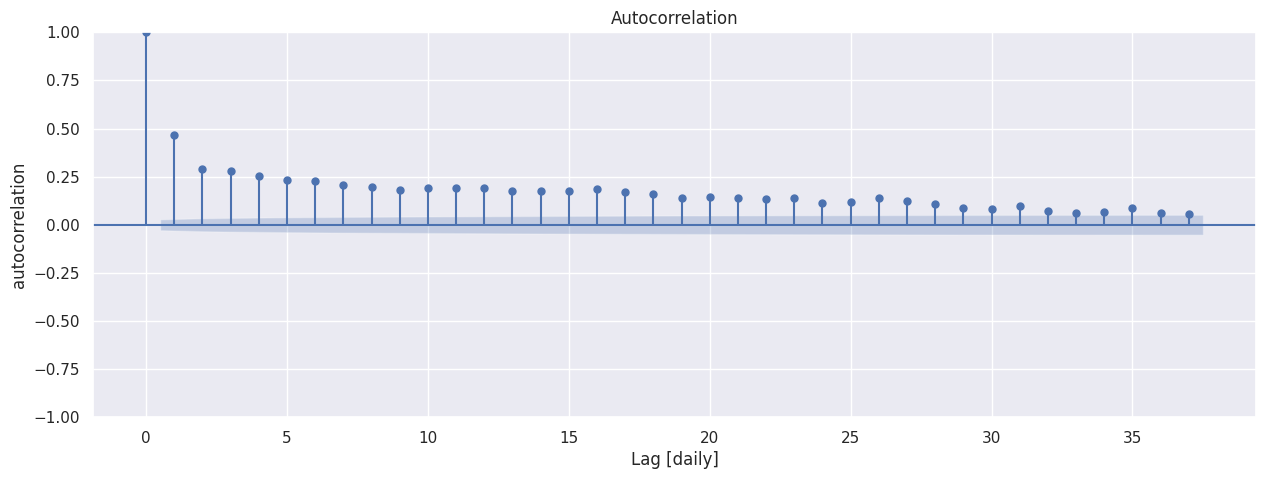

In [47]:
# precipitation
plot_acf(precipitation);

# label chart
plt.xlabel('Lag [daily]')
plt.ylabel('autocorrelation');

In [48]:
#@title Build ARIMA model for temperature

# setting  hyperparameters for ARIMA
p_params = range(0, 6,1)
q_params = range(0, 3, 1)

# Create dictionary to store MAEs
mae_grid = dict()
for p in p_params:
    mae_grid[p] = list()
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(training_temp.values, order = order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(training_temp[p:], y_pred[p:])
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

Trained ARIMA (0, 0, 0) in 0.54 seconds.
Trained ARIMA (0, 0, 1) in 0.68 seconds.
Trained ARIMA (0, 0, 2) in 1.19 seconds.
Trained ARIMA (1, 0, 0) in 0.35 seconds.
Trained ARIMA (1, 0, 1) in 1.1 seconds.
Trained ARIMA (1, 0, 2) in 3.04 seconds.
Trained ARIMA (2, 0, 0) in 0.42 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Trained ARIMA (2, 0, 1) in 6.1 seconds.
Trained ARIMA (2, 0, 2) in 4.37 seconds.
Trained ARIMA (3, 0, 0) in 1.27 seconds.
Trained ARIMA (3, 0, 1) in 4.99 seconds.
Trained ARIMA (3, 0, 2) in 9.23 seconds.
Trained ARIMA (4, 0, 0) in 1.82 seconds.
Trained ARIMA (4, 0, 1) in 7.29 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (4, 0, 2) in 9.77 seconds.
Trained ARIMA (5, 0, 0) in 4.4 seconds.
Trained ARIMA (5, 0, 1) in 8.26 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (5, 0, 2) in 15.58 seconds.


In [49]:
# Converting the mean absolute errors into a dataframe
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,1,2,3,4,5
0,1.2029,0.4998,0.4973,0.4894,0.4881,0.4873
1,0.7906,0.4959,0.4838,0.4827,0.4826,0.4823
2,0.6613,0.4853,0.4826,0.4824,0.4825,0.4825


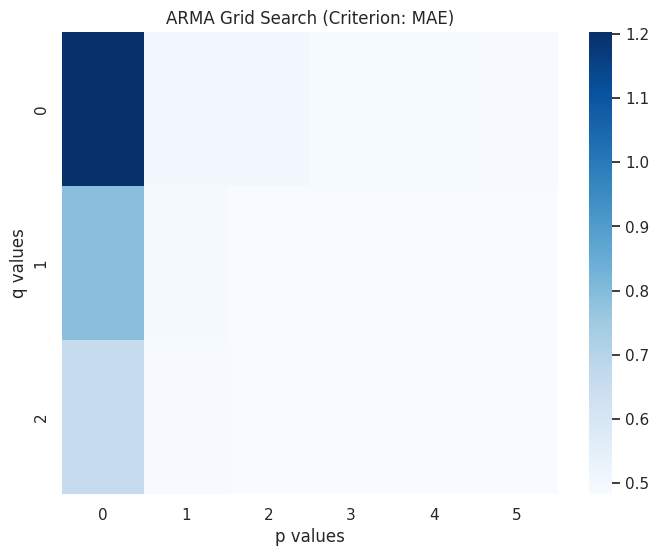

In [50]:
# visualizing 'mae_df'
sns.set(rc = {'figure.figsize': (8, 6)})
sns.heatmap(mae_df, cmap = "Blues")
plt.xlabel("p values")
plt.ylabel("q values")
plt.title("ARMA Grid Search (Criterion: MAE)");

The best combinatoin (order) for the ARIMA model will be `ARIMA(5, 0, 1)` with mean absolute error of `0.4823` for `temperature`.

In [51]:
# @title build ARIMA(5, 0, 1)
order = (5, 0, 1)
temp_arima = ARIMA(training_temp, order = order).fit()

# make predictions
pred = temp_arima.predict()

# calculate mean absolute error
mean_absolute_error(training_temp, pred)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



0.48255401683573257

In [52]:
#@title Visualize the predictions of the ARIMA(5, 0, 1) temperature model
dt = pd.DataFrame(
    {
        'true temperature': training_temp.values,
        'predicted': pred
    },
    index = training_temp.index
)

fig = px.line(dt, title = 'Temperature ARIMA(5, 0, 1) predictions')
fig.show()

In [53]:
#@title Build ARIMA model for precipitation

# setting  hyperparameters for ARIMA
p_params = range(0, 15,1)
q_params = range(0, 2, 1)

# Create dictionary to store MAEs
mae_grid = dict()
for p in p_params:
    mae_grid[p] = list()
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(training_prec, order = order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(training_prec[p:], y_pred[p:])
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (0, 0, 0) in 0.61 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (0, 0, 1) in 0.66 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (1, 0, 0) in 0.21 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (1, 0, 1) in 1.01 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (2, 0, 0) in 0.63 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Trained ARIMA (2, 0, 1) in 4.43 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (3, 0, 0) in 0.84 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (3, 0, 1) in 3.41 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (4, 0, 0) in 1.08 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (4, 0, 1) in 5.44 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (5, 0, 0) in 2.53 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (5, 0, 1) in 7.68 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (6, 0, 0) in 1.47 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (6, 0, 1) in 9.92 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (7, 0, 0) in 2.19 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (7, 0, 1) in 11.96 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (8, 0, 0) in 2.18 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (8, 0, 1) in 6.47 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (9, 0, 0) in 6.36 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (9, 0, 1) in 21.51 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (10, 0, 0) in 4.59 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (10, 0, 1) in 20.05 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (11, 0, 0) in 4.54 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (11, 0, 1) in 27.28 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (12, 0, 0) in 9.29 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (12, 0, 1) in 27.33 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (13, 0, 0) in 12.39 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (13, 0, 1) in 35.88 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (14, 0, 0) in 13.26 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (14, 0, 1) in 39.48 seconds.


In [54]:
# Converting the mean absolute errors into a dataframe
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,3.5376,2.6941,2.6483,2.6088,2.5896,2.5889,2.5823,2.5698,2.5702,2.5681,2.5537,2.5507,2.5475,2.5443,2.5406
1,3.0072,2.6063,2.5429,2.5442,2.5427,2.5425,2.5389,2.5388,2.5689,2.5341,2.5298,2.5313,2.5305,2.5312,2.5327


The best model for precipitation, according to the loop is ARIMA(12, 0, 1). However, it is computationally expensive as it takes more time to train `(27.16 seconds)`. The errors are quite close to each other. In this case, we can choose a model with decent error and less time of computation. This is a wise decision to make in machine learning 😀.
**`Let's just keep the formal model.  It is quite reliable.`**

In [55]:
temp_arima.forecast(steps = 7)

2020-08-06    22.635892
2020-08-07    22.967803
2020-08-08    23.139996
2020-08-09    23.246425
2020-08-10    23.300809
2020-08-11    23.333266
2020-08-12    23.361237
Freq: D, Name: predicted_mean, dtype: float64

# **Some fast ways ⏫ to deploy the models as functions:**

In [56]:
#@title Build a function to predict temperature and rainfall for users

from datetime import datetime, timedelta

def forecast_temperature(start_date, forecast_days, model=temp_ar):
  """
  Forecasts temperature values for a specified time frame.

  Args:
    start_date: The starting date for the forecast in YYYY-MM-DD format.
    forecast_days: The number of days to forecast.
    model: The time series model used for forecasting.

  Returns:
    A Pandas DataFrame with temperature forecasts indexed by timestamps.
  """

  # Parse the start date
  start_date_obj = datetime.strptime(start_date, "%Y-%m-%d")

  # Generate a list of forecast dates
  forecast_dates = [start_date_obj + timedelta(days=i) for i in range(forecast_days)]

  # Forecast temperature values for each date
  forecast_values = model.predict(start=start_date_obj, end=forecast_dates[-1])

  # Create a Pandas DataFrame
  data = {"Date": forecast_dates, "Temperature": forecast_values}
  df = pd.DataFrame(data)

  # Set Date as the index
  df.set_index("Date", inplace=True)

  return df

# Example usage
start_date = "2023-12-14"
forecast_days = 7
forecast_df = forecast_temperature(start_date, forecast_days)

# Print the forecast data
print(forecast_df)

            Temperature
Date                   
2023-12-14    25.893003
2023-12-15    25.893003
2023-12-16    25.893003
2023-12-17    25.893003
2023-12-18    25.893003
2023-12-19    25.893003
2023-12-20    25.893003


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.



In [57]:
#@title Build a function to predict temperature and rainfall for users

from datetime import datetime, timedelta

def forecast(start_date, forecast_days):
  """
  Forecasts temperature values for a specified time frame.

  Args:
    start_date: The starting date for the forecast in YYYY-MM-DD format.
    forecast_days: The number of days to forecast.
    model: The time series model used for forecasting.

  Returns:
    A Pandas DataFrame with temperature forecasts indexed by timestamps.
  """

  # Parse the start date
  start_date_obj = datetime.strptime(start_date, "%Y-%m-%d")

  # Generate a list of forecast dates
  forecast_dates = [start_date_obj + timedelta(days=i) for i in range(forecast_days)]

  # Forecast temperature and rainfall values for each date
  forecast_temp = temp_ar.predict(start=start_date_obj, end=forecast_dates[-1])
  forecast_prec = prec_ar.predict(start=start_date_obj, end=forecast_dates[-1])

  # Create a Pandas DataFrame
  data = {"Date": forecast_dates, "Temperature": forecast_temp, 'Precipitation': forecast_prec}
  df = pd.DataFrame(data)

  # Set Date as the index
  df.set_index("Date", inplace=True)

  return df

# Example usage
start_date = "2023-12-14"
forecast_days = 7
forecast_df = forecast(start_date, forecast_days)

# Print the forecast data
forecast_df

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.



,Temperature,Precipitation
Date,,
2023-12-14,25.893003,3.920207
2023-12-15,25.893003,3.920207
2023-12-16,25.893003,3.920207
2023-12-17,25.893003,3.920207
2023-12-18,25.893003,3.920207
2023-12-19,25.893003,3.920207
2023-12-20,25.893003,3.920207


In [58]:
forecast_temperature(start_date='2023-04-01', forecast_days=7)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.



,Temperature
Date,
2023-04-01,25.893003
2023-04-02,25.893003
2023-04-03,25.893003
2023-04-04,25.893003
2023-04-05,25.893003
2023-04-06,25.893003
2023-04-07,25.893003


In [64]:
from datetime import datetime, timedelta

def forecast(start_date, forecast_days):
  """
  Forecasts temperature values for a specified time frame.

  Args:
    start_date: The starting date for the forecast in YYYY-MM-DD format.
    forecast_days: The number of days to forecast.
    model: The time series model used for forecasting.

  Returns:
    A Pandas DataFrame with temperature forecasts indexed by timestamps.
  """

  # Parse the start date
  start_date_obj = datetime.strptime(start_date, "%Y-%m-%d")

  # Generate a list of forecast dates
  forecast_dates = [start_date_obj + timedelta(days=i) for i in range(forecast_days)]

  # Forecast temperature and rainfall values for each date
  forecast_temp = temp_ar.forecast(steps=forecast_days)
  forecast_prec = prec_ar.forecast(steps=forecast_days)

  # convert predictions to dataframe
  df = pd.DataFrame(
      {
          'temperature': forecast_temp.values,
          'precipitation': forecast_prec.values
      },
      index = forecast_dates
  )

  return df

In [65]:
forecast(start_date='2023-04-01', forecast_days=7)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.



,temperature,precipitation
2023-04-01,22.584902,1.318802
2023-04-02,22.823428,1.861245
2023-04-03,22.897120,2.151270
2023-04-04,22.965929,2.398949
2023-04-05,23.044107,2.659473
2023-04-06,23.155025,2.903996
2023-04-07,23.266238,3.085516
